# SSP emissions runs using CMIP6 calibrations

This notebook gives an example of running the SSP scenarios in FaIR using pre-calculated climate response calibrations from 66 CMIP6 models for a total of 8$\times$66 = 528 ensemble members in parallel. We will run in stochastic mode to demonstrate internal variability.

This demonstrates the speed in which FaIR can run scenarios and configurations in parallel. This might be a good template notebook to use for SSP emissions-driven runs.

Refer to the `basic_emissions_run_example` for more detail on setting up a run step by step; this notebook will be a little lighter on the detail, but hopefully still enough to be useful.

## 0. import required modules

we'll enable autoreload as a legacy of development

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

## 1. initialise FaIR

We want to enable the methane lifetime routine that is a function of SLCFs and reactive gases, i.e. using the coefficients and feedbacks from [Thornhill et al. 2021](https://acp.copernicus.org/articles/21/853/2021/acp-21-853-2021.html) and [Skeie et al. 2020](https://www.nature.com/articles/s41612-020-00131-0). We set this option in the initialiser this time.

In [4]:
f = FAIR(ch4_method='thornhill2021')

## 2. Define time horizon

create world running from 1750 to 2100, at 1-year intervals

In [5]:
f.define_time(1750, 2100, 1)

## 3. Define scenarios

We'll take the SSPs; important that the names are consistent with those in the RCMIP database

In [6]:
# Define SSP scenarios
scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
f.define_scenarios(scenarios)

## 4. Define configs

Our list of configs are going to be each CMIP6 climate model's 4xCO2 response, which has been pre-calculated in the calibration notebooks.

We could also modify the response for different aerosol, ozone, methane lifetime tunings etc., but not every model has this data available.

In [7]:
df = pd.read_csv("../data/calibration/4xCO2_cummins_ebm3.csv")
models = df['model'].unique()
configs = []

for imodel, model in enumerate(models):
    for run in df.loc[df['model']==model, 'run']:
        configs.append(f"{model}_{run}")
f.define_configs(configs)

## 5. Define species and properties

FaIR contains a few helper functions that populate the model with sensible defaults. One is the `read_properties` function that obtains default species (the kitchen sink) and their properties for an emissions-driven run

In [8]:
species, properties = read_properties()
#species = list(properties.keys())

In [9]:
species[:5]

['CO2 FFI', 'CO2 AFOLU', 'CO2', 'CH4', 'N2O']

In [10]:
properties['CO2 FFI']

{'type': 'co2 ffi',
 'input_mode': 'emissions',
 'greenhouse_gas': False,
 'aerosol_chemistry_from_emissions': False,
 'aerosol_chemistry_from_concentration': False}

In [11]:
f.define_species(species, properties)

## ~6. Modify run options~

Not required, because we set our run options in step 1.

## 7. Create input and output data

In [12]:
f.allocate()

## 8. Fill in the data

### 8a. get default species configs

Again we read in a default list of species configs that will apply to each config. If you want to change specific configs then you can still use this function to set defaults and tweak what you need. We will do this with the methane lifetime, which has a different value calibrated for the Thornhill 2021 lifetime option.

I'm also going to subtract the RCMIP 1750 emissions from CH4 and N2O. This is not in the default configs.

In [13]:
f.fill_species_configs()
fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

### 8b. fill emissions

grab emissions (+solar and volcanic forcing) from RCMIP datasets using the `fill_from_rcmip` helper function. This function automatically selects the emissions, concentration or forcing you want depending on the `properties` for each of the SSP scenarios defined.

I'm then going to make one change: replace the volcanic dataset with the AR6 volcanic dataset, as I want to compare the impact of monthly volcanic forcing in the monthly comparison.

We also need to initialise the first timestep of the run in terms of its per-species forcing, temperature, cumulative and airborne emissions. We set these all to zero. The concentration in the first timestep will be set to the baseline concentration, which are the IPCC AR6 1750 values.

In [14]:
df_volcanic = pd.read_csv('../data/forcing/volcanic_ERF_monthly_-950001-201912.csv', index_col='year')
df_volcanic[1750:].head()

,erf
year,
1750.000000,0.246406
1750.083333,0.246408
1750.166667,0.246409
1750.250000,0.246410
1750.333333,0.246411


In [15]:
f.fill_from_rcmip()

# overwrite volcanic
volcanic_forcing = np.zeros(351)
volcanic_forcing[:271] = df_volcanic[1749:].groupby(np.ceil(df_volcanic[1749:].index) // 1).mean().squeeze().values
fill(f.forcing, volcanic_forcing[:, None, None], specie="Volcanic")  # sometimes need to expand the array

initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

### 8c. fill climate configs

Take pre-calculated values from the Cummins et al. three layer model. We will use a reproducible random seed to define the stochastic behaviour.

In [16]:
df = pd.read_csv("../data/calibration/4xCO2_cummins_ebm3.csv")
models = df['model'].unique()

seed = 1355763

for config in configs:
    model, run = config.split('_')
    condition = (df['model']==model) & (df['run']==run)
    fill(f.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
    fill(f.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
    fill(f.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)
    fill(f.climate_configs['gamma_autocorrelation'], df.loc[condition, 'gamma'].values[0], config=config)
    fill(f.climate_configs['sigma_eta'], df.loc[condition, 'sigma_eta'].values[0], config=config)
    fill(f.climate_configs['sigma_xi'], df.loc[condition, 'sigma_xi'].values[0], config=config)
    fill(f.climate_configs['stochastic_run'], True, config=config)
    fill(f.climate_configs['use_seed'], True, config=config)
    fill(f.climate_configs['seed'], seed, config=config)
    
    seed = seed + 399

## 9. Run FaIR

look at it go.

You can turn off the progress bar with `progress=False`.

In [17]:
f.run()

Running 528 projections in parallel:   0%|          | 0/350 [00:00<?, ?timesteps/s]

In [18]:
# this works but creates a large file that we don't want to commit to GitHub
#f.to_netcdf('../tests/test_data/cmip6_ssp_emissions_run.nc')

## 10. Make some nice plots

Presently this is accessed using the `xarray` notation; perhaps we can write a nice filter function like I did with `fill` and `initialise`.

The output attributes of `FAIR` of interest are
- temperature (layer=0 is surface)
- emissions (an output for GHGs driven with concentration)
- concentration (as above, vice versa)
- forcing: the per-species effective radiative forcing
- forcing_sum: the total forcing
- airborne_emissions: total emissions of a GHG remaining in the atmosphere
- airborne_fraction: the fraction of GHG emissions remaining in the atmosphere
- alpha_lifetime: the scaling factor to unperturbed lifetime. Mutiply the two values to get the atmospheric lifetime of a greenhouse gas (see methane example below)
- cumulative_emissions
- ocean_heat_content_change
- toa_imbalance
- stochastic_forcing: if stochastic variability is activated, the non-deterministic part of the forcing

Text(0, 0.5, 'Temperature anomaly (K)')

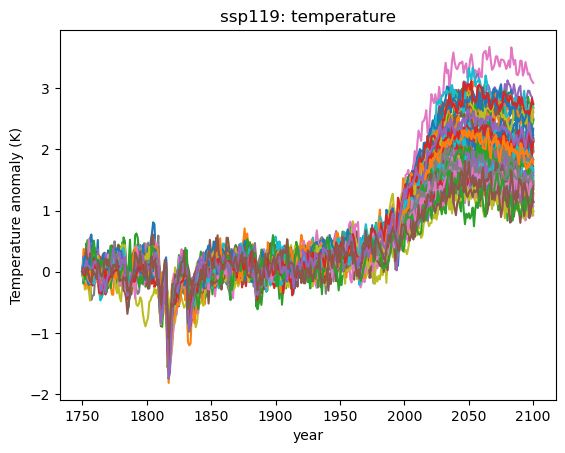

In [19]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp119', layer=0)], label=f.configs);
pl.title('ssp119: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'methane lifetime (yr)')

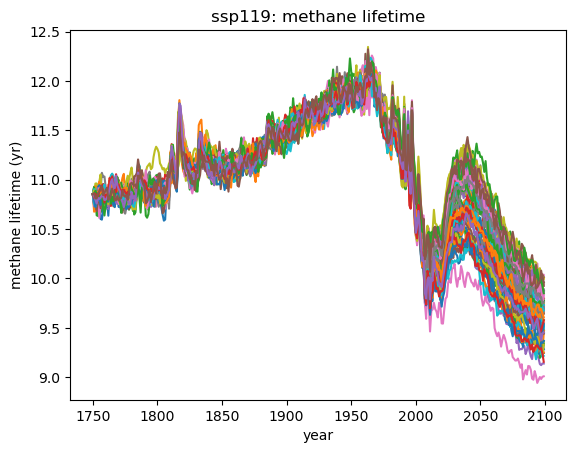

In [20]:
pl.plot(f.timebounds, f.species_configs['unperturbed_lifetime'].loc[dict(specie='CH4', gasbox=0)].data * f.alpha_lifetime.loc[dict(scenario='ssp119', specie='CH4')], label=f.configs);
pl.title('ssp119: methane lifetime')
pl.xlabel('year')
pl.ylabel('methane lifetime (yr)')

Text(0, 0.5, 'W/m2')

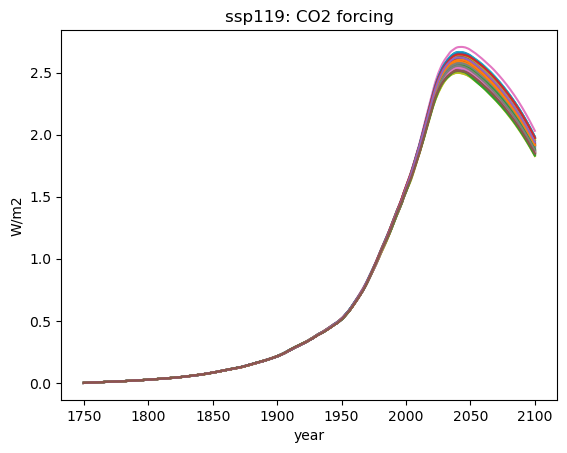

In [21]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='CO2')], label=f.configs);
pl.title('ssp119: CO2 forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

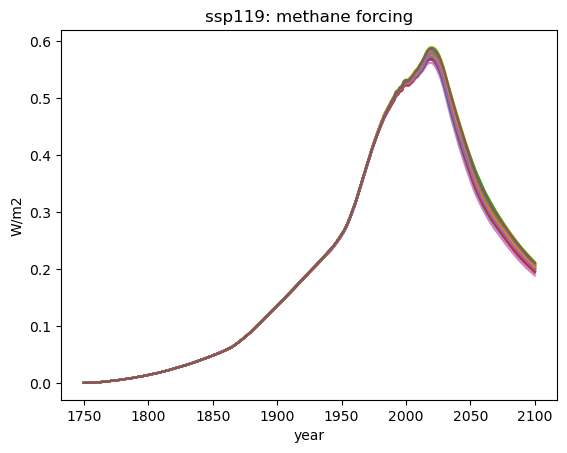

In [22]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='CH4')], label=f.configs);
pl.title('ssp119: methane forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'Temperature anomaly (K)')

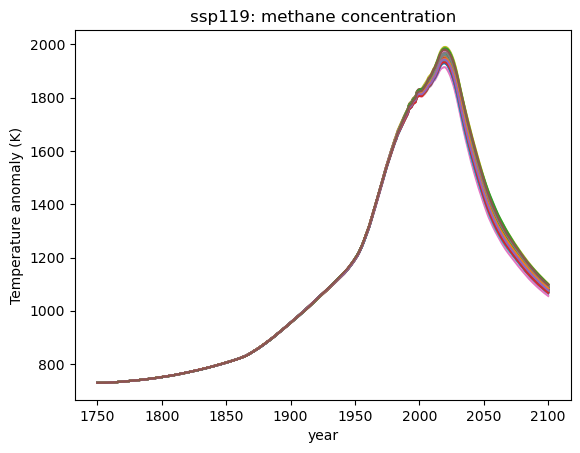

In [23]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='ssp119', specie='CH4')], label=f.configs);
pl.title('ssp119: methane concentration')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'ppt')

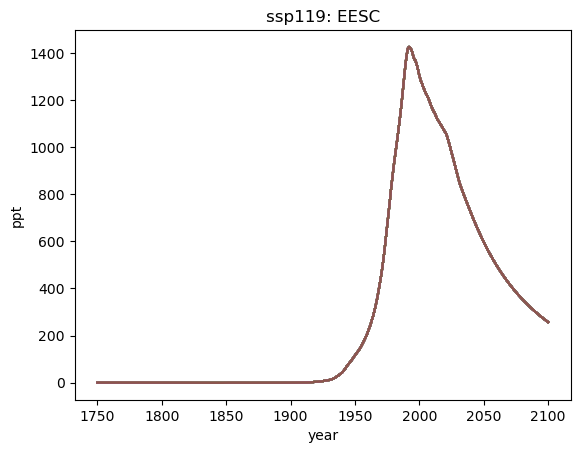

In [24]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='ssp119', specie='Equivalent effective stratospheric chlorine')], label=f.configs);
pl.title('ssp119: EESC')
pl.xlabel('year')
pl.ylabel('ppt')

Text(0, 0.5, 'ppb')

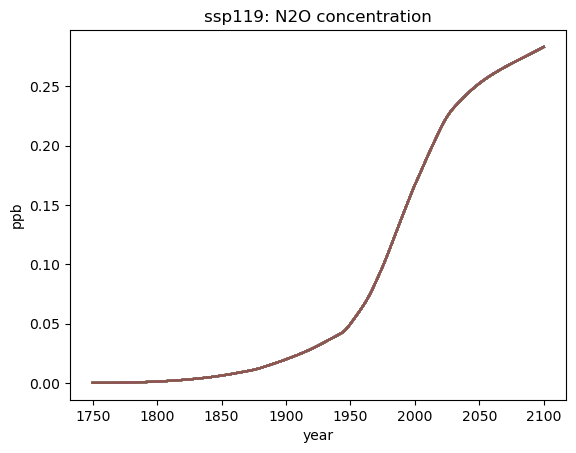

In [25]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='N2O')], label=f.configs);
pl.title('ssp119: N2O concentration')
pl.xlabel('year')
pl.ylabel('ppb')

Text(0, 0.5, 'W/m2')

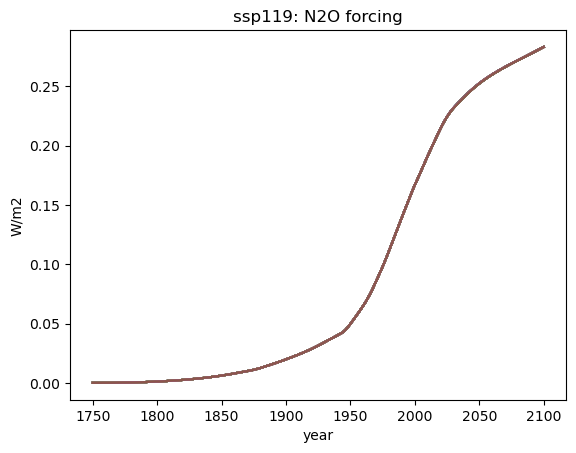

In [26]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='N2O')], label=f.configs);
pl.title('ssp119: N2O forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'ppt')

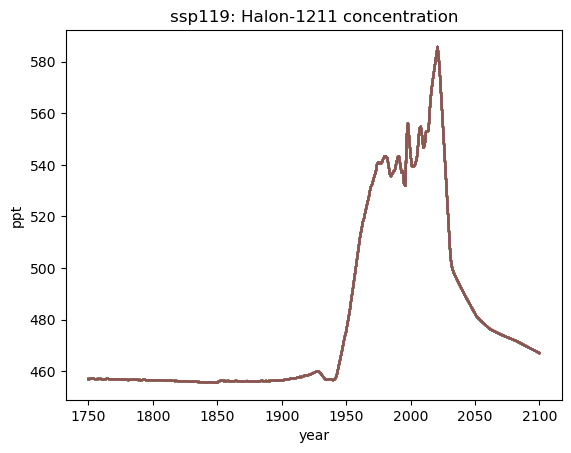

In [27]:
pl.plot(f.timebounds, f.concentration.loc[dict(scenario='ssp119', specie='CH3Cl')], label=f.configs);
pl.title('ssp119: Halon-1211 concentration')
pl.xlabel('year')
pl.ylabel('ppt')

Text(0, 0.5, 'W/m2')

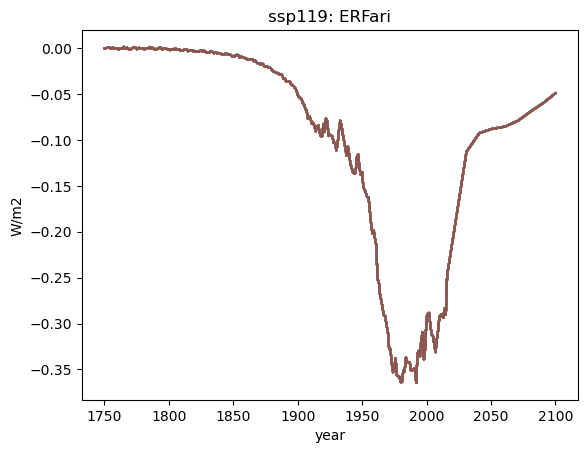

In [28]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Aerosol-radiation interactions')], label=f.configs);
pl.title('ssp119: ERFari')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

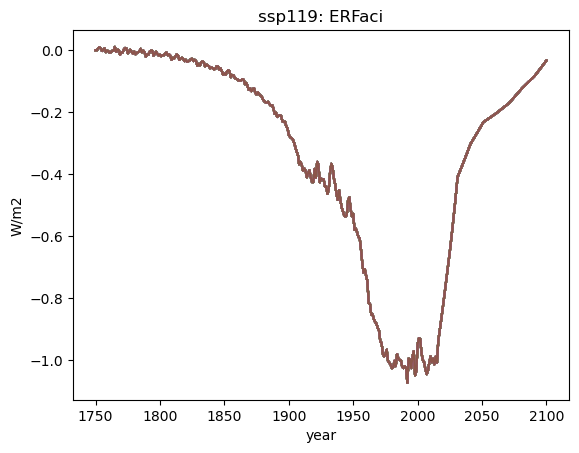

In [29]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Aerosol-cloud interactions')], label=f.configs);
pl.title('ssp119: ERFaci')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

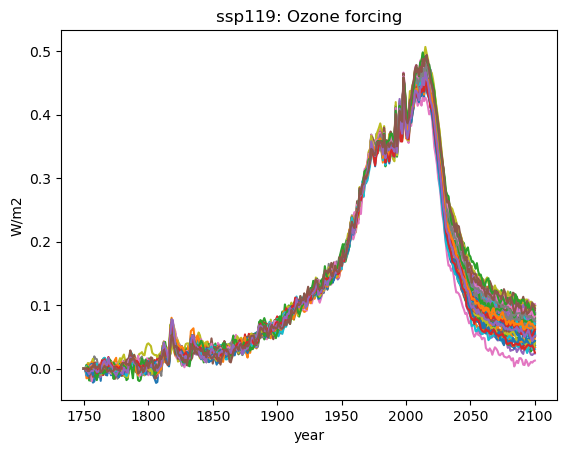

In [30]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Ozone')], label=f.configs);
pl.title('ssp119: Ozone forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

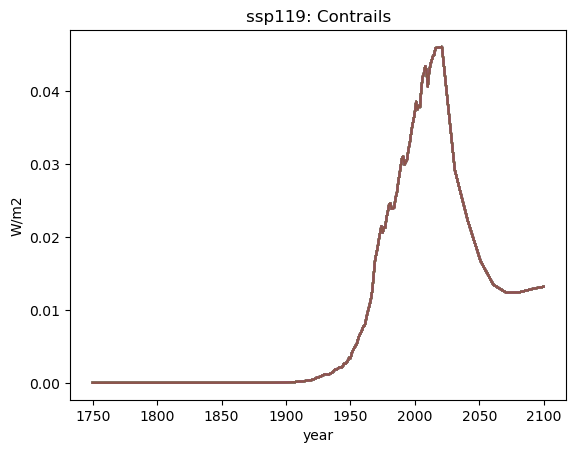

In [31]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Contrails')], label=f.configs);
pl.title('ssp119: Contrails')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

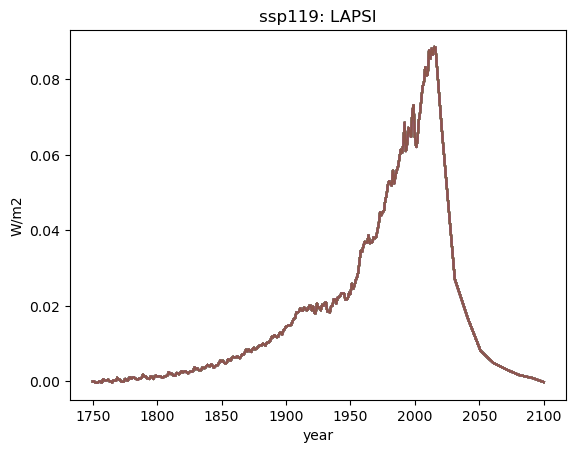

In [32]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Light absorbing particles on snow and ice')], label=f.configs);
pl.title('ssp119: LAPSI')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

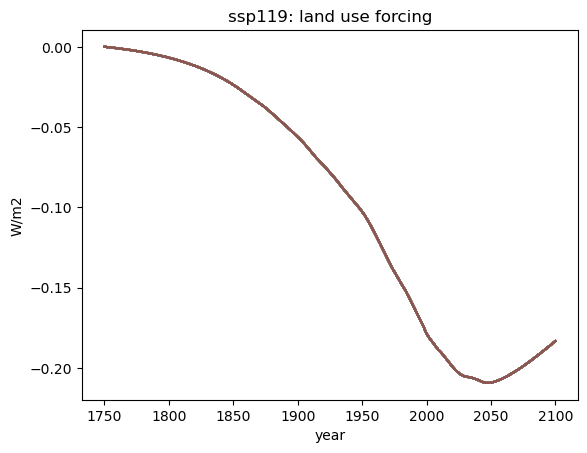

In [33]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Land use')], label=f.configs);
pl.title('ssp119: land use forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

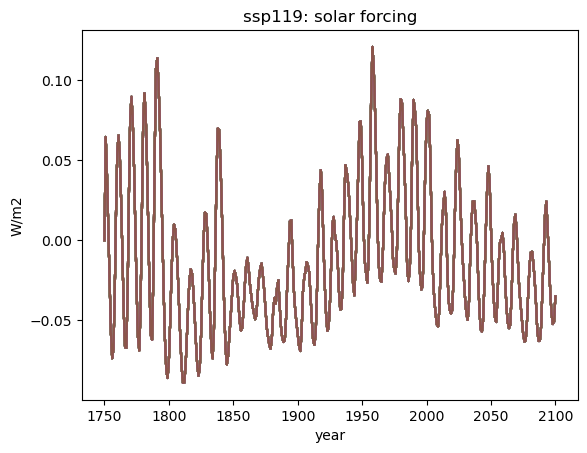

In [34]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Solar')], label=f.configs);
pl.title('ssp119: solar forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

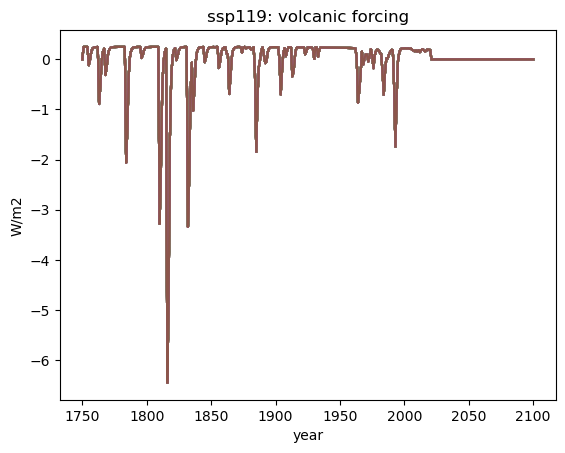

In [35]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Volcanic')], label=f.configs);
pl.title('ssp119: volcanic forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

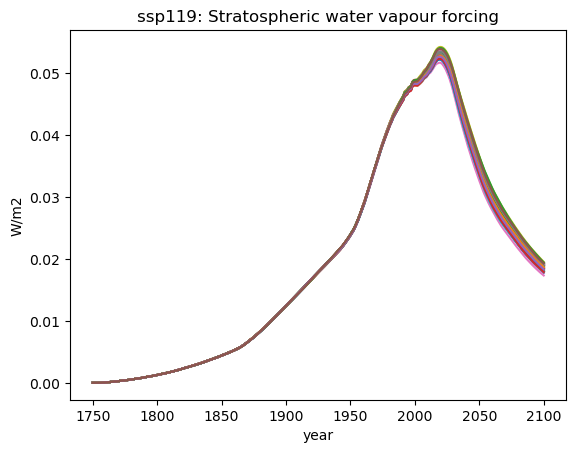

In [36]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp119', specie='Stratospheric water vapour')], label=f.configs);
pl.title('ssp119: Stratospheric water vapour forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'Temperature anomaly (K)')

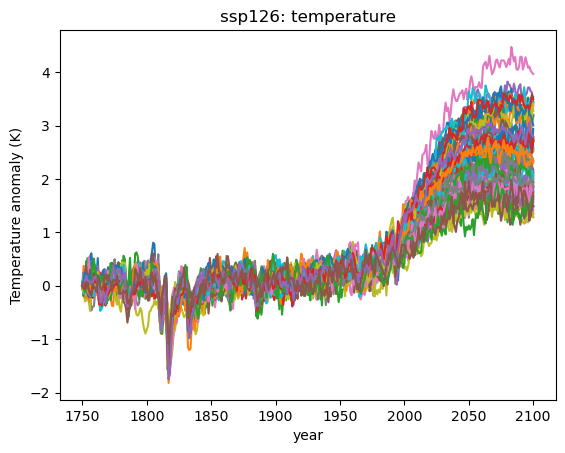

In [37]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp126', layer=0)], label=f.configs);
pl.title('ssp126: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
#pl.legend()

Text(0, 0.5, 'Temperature anomaly (K)')

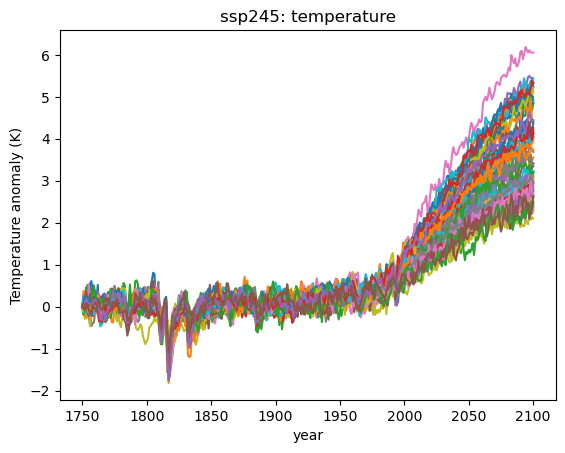

In [38]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp245', layer=0)], label=f.configs);
pl.title('ssp245: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
#pl.legend()

Text(0, 0.5, 'Temperature anomaly (K)')

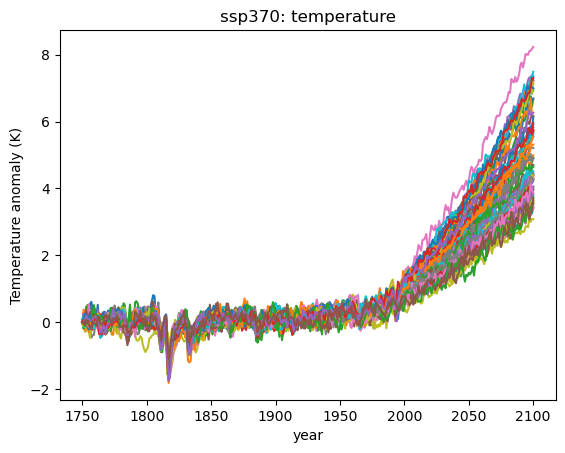

In [39]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp370', layer=0)], label=f.configs);
pl.title('ssp370: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
#pl.legend()

Text(0, 0.5, 'Temperature anomaly (K)')

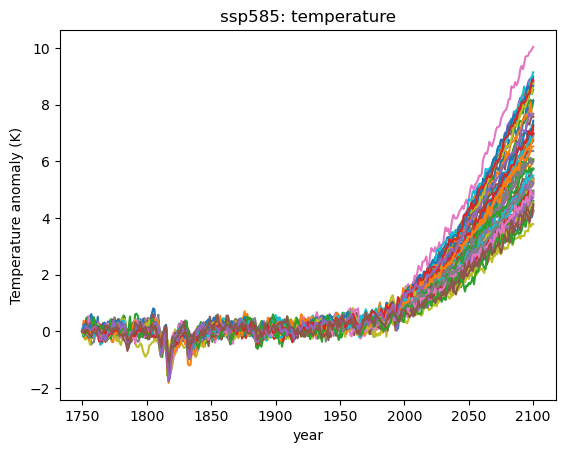

In [40]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp585', layer=0)], label=f.configs);
pl.title('ssp585: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
#pl.legend()

Text(0, 0.5, 'W/m2')

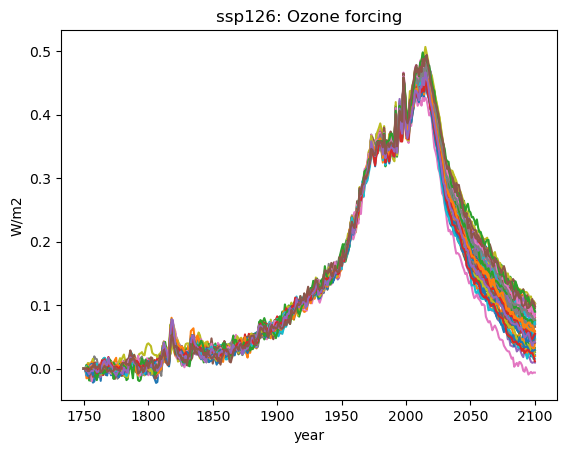

In [41]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp126', specie='Ozone')], label=f.configs);
pl.title('ssp126: Ozone forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

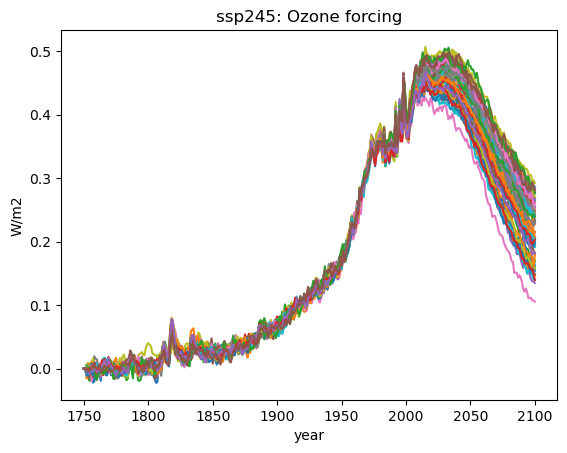

In [42]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp245', specie='Ozone')], label=f.configs);
pl.title('ssp245: Ozone forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

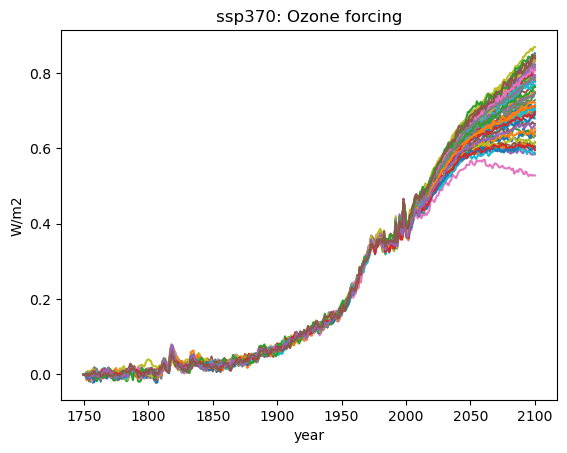

In [43]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp370', specie='Ozone')], label=f.configs);
pl.title('ssp370: Ozone forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'W/m2')

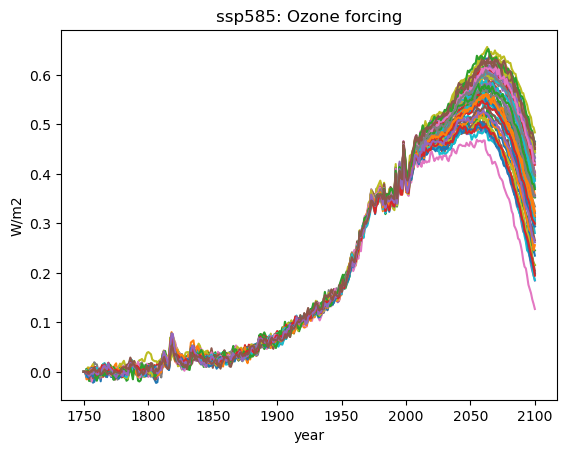

In [44]:
pl.plot(f.timebounds, f.forcing.loc[dict(scenario='ssp585', specie='Ozone')], label=f.configs);
pl.title('ssp585: Ozone forcing')
pl.xlabel('year')
pl.ylabel('W/m2')

Text(0, 0.5, 'GtCO2')

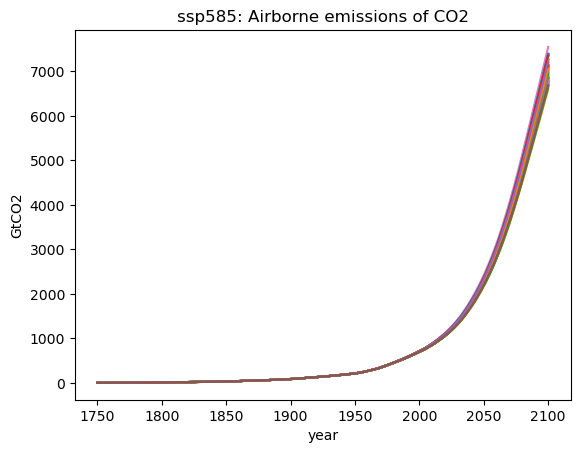

In [45]:
pl.plot(f.timebounds, f.airborne_emissions.loc[dict(scenario='ssp585', specie='CO2')], label=f.configs);
pl.title('ssp585: Airborne emissions of CO2')
pl.xlabel('year')
pl.ylabel('GtCO2')

Text(0, 0.5, '[1]')

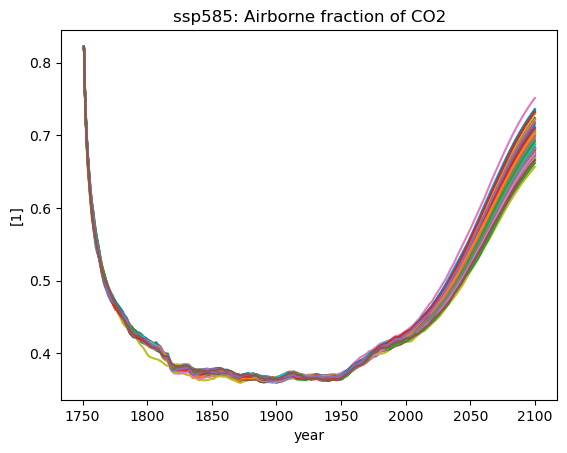

In [46]:
pl.plot(f.timebounds, f.airborne_fraction.loc[dict(scenario='ssp585', specie='CO2')], label=f.configs);
pl.title('ssp585: Airborne fraction of CO2')
pl.xlabel('year')
pl.ylabel('[1]')

Text(0, 0.5, 'GtCO2')

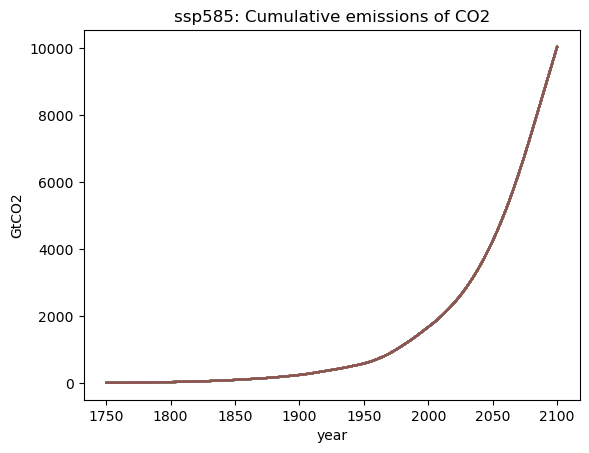

In [47]:
pl.plot(f.timebounds, f.cumulative_emissions.loc[dict(scenario='ssp585', specie='CO2')], label=f.configs);
pl.title('ssp585: Cumulative emissions of CO2')
pl.xlabel('year')
pl.ylabel('GtCO2')

Text(0, 0.5, 'J')

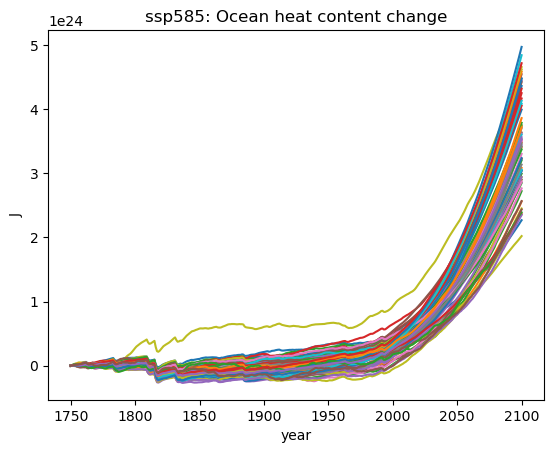

In [48]:
pl.plot(f.timebounds, f.ocean_heat_content_change.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Ocean heat content change')
pl.xlabel('year')
pl.ylabel('J')

Text(0, 0.5, 'W m$^{-2}$')

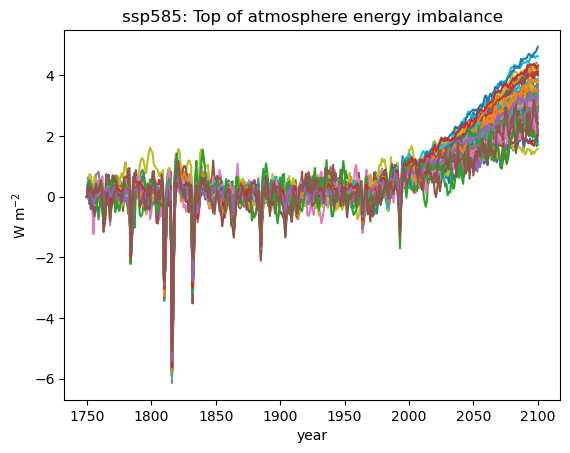

In [49]:
pl.plot(f.timebounds, f.toa_imbalance.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Top of atmosphere energy imbalance')
pl.xlabel('year')
pl.ylabel('W m$^{-2}$')

Text(0, 0.5, 'W m$^{-2}$')

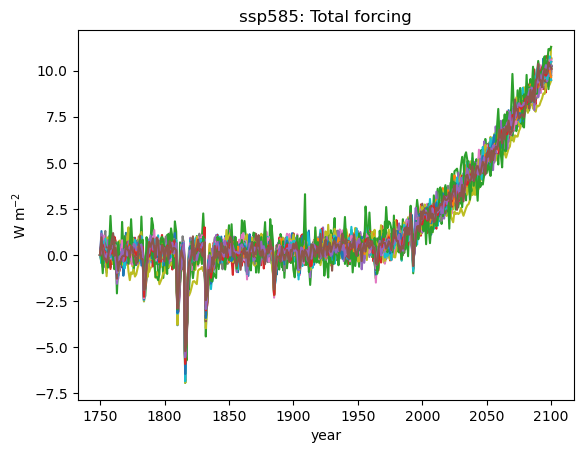

In [50]:
pl.plot(f.timebounds, f.stochastic_forcing.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Total forcing')
pl.xlabel('year')
pl.ylabel('W m$^{-2}$')

Text(0, 0.5, 'W m$^{-2}$')

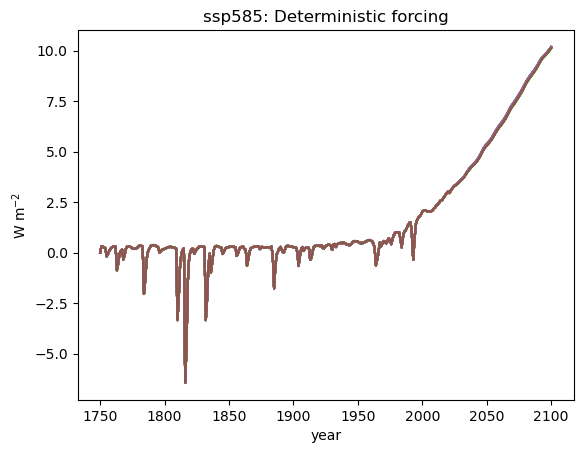

In [51]:
pl.plot(f.timebounds, f.forcing_sum.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Deterministic forcing')
pl.xlabel('year')
pl.ylabel('W m$^{-2}$')

Text(0, 0.5, 'W m$^{-2}$')

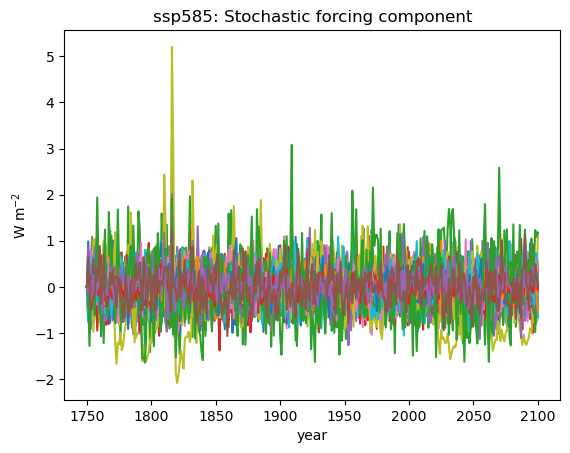

In [52]:
pl.plot(f.timebounds, f.stochastic_forcing.loc[dict(scenario='ssp585')]-f.forcing_sum.loc[dict(scenario='ssp585')], label=f.configs);
pl.title('ssp585: Stochastic forcing component')
pl.xlabel('year')
pl.ylabel('W m$^{-2}$')